In [12]:
import numpy as np
import copy
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

In [13]:
class MiniGrid:

    def __init__(self, n=3):
        self.n = n
        self.done = True
        self.steps = 0

        self.agent_pos = [0, 0]

        self.actions = {"up": 0, "down": 1, "left": 2, "right": 3}
        self.elements = {"agent": 2, "goal": 1, "floor": 0, "trap": -1, "wall": -2}

        self.obs_space = self.n * self.n
        self.action_space = len(self.actions.keys())

    def reset(self):
        self.obs = np.zeros((self.n, self.n))

        # set agent position
        self.agent_pos = [0, 0]
        self.obs[self.agent_pos[0], self.agent_pos[1]] = self.elements["agent"]
        # set goal position
        self.obs[-1, -1] = self.elements["goal"]
        # add additional obstacles
        self._add_obstactles(self.obs)

        return copy.deepcopy(self.obs), copy.deepcopy(self.agent_pos)

    def _add_obstactles(self, obs):
        # obs[1, 1] = self.elements["trap"]
        # obs[1, 1] = self.elements["wall"]
        pass

    def _check_done(self, reward, done):
        if self.obs[self.agent_pos[0], self.agent_pos[1]] == self.elements["trap"]:
            reward = -1
            done = True
        elif self.obs[self.agent_pos[0], self.agent_pos[1]] == self.elements["goal"]:
            reward = 1
            done = True
        return reward, done

    def step(self, action):
        reward = 0
        done = False

        # remove agent from grid
        self.obs[self.agent_pos[0], self.agent_pos[1]] = self.elements["floor"]

        # if going UP
        if action == self.actions["up"]:
            # if not border and no wall collision
            if self.agent_pos[1] > 0 and self.obs[self.agent_pos[0], self.agent_pos[1] - 1] != self.elements["wall"]:
                self.agent_pos = [self.agent_pos[0], self.agent_pos[1] - 1]
                reward, done = self._check_done(reward, done)
        # if going DOWN
        if action == self.actions["down"]:
            # if not border and no wall collision
            if self.agent_pos[1] < self.n - 1 and self.obs[self.agent_pos[0], self.agent_pos[1] + 1] != self.elements["wall"]:
                self.agent_pos = [self.agent_pos[0], self.agent_pos[1] + 1]
                reward, done = self._check_done(reward, done)

        # if going LEFT
        if action == self.actions["left"]:
            # if not border and no wall collision
            if self.agent_pos[0] > 0 and self.obs[self.agent_pos[0] - 1, self.agent_pos[1]] != self.elements["wall"]:
                self.agent_pos = [self.agent_pos[0] - 1, self.agent_pos[1]]
                reward, done = self._check_done(reward, done)
        # if going RIGHT
        if action == self.actions["right"]:
            # if not border and no wall collision
            if self.agent_pos[0] < self.n - 1 and self.obs[self.agent_pos[0] + 1, self.agent_pos[1]] != self.elements["wall"]:
                self.agent_pos = [self.agent_pos[0] + 1, self.agent_pos[1]]
                reward, done = self._check_done(reward, done)

        # add agent to grid on new position
        self.obs[self.agent_pos[0], self.agent_pos[1]] = self.elements["agent"]

        return copy.deepcopy(self.obs), reward, done, copy.deepcopy(self.agent_pos)

    def get_all_transitions(self):
        states = []
        states_pos = []
        actions = []
        next_states = []
        next_states_pos = []
        rewards = []
        dones = []
        excluded = []

        for i in range(self.n):
            for j in range(self.n):
                grid = np.zeros((self.n, self.n))
                grid[-1, -1] = self.elements["goal"]
                self._add_obstactles(grid)

                state = copy.deepcopy(grid)
                if state[i, j] == 0:
                    state[i, j] = self.elements["agent"]
                else:
                    excluded.append((i, j))
                    continue

                for a in range(len(self.actions.keys())):
                    reward = 0
                    done = 0
                    next_state = copy.deepcopy(grid)
                    if a == 0:
                        if j > 0 and next_state[i, j - 1] != self.elements["wall"]:
                            reward = next_state[i, j - 1]
                            done = np.abs(next_state[i, j - 1])
                            next_state[i, j - 1] = self.elements["agent"]
                            next_states_pos.append((i, j - 1))
                        else:
                            next_state = copy.deepcopy(state)
                            next_states_pos.append((i, j))
                    elif a == 1:
                        if j < self.n - 1 and next_state[i, j + 1] != self.elements["wall"]:
                            reward = next_state[i, j + 1]
                            done = np.abs(next_state[i, j + 1])
                            next_state[i, j + 1] = self.elements["agent"]
                            next_states_pos.append((i, j + 1))
                        else:
                            next_state = copy.deepcopy(state)
                            next_states_pos.append((i, j))
                    elif a == 2:
                        if i > 0 and next_state[i - 1, j] != self.elements["wall"]:
                            reward = next_state[i - 1, j]
                            done = np.abs(next_state[i - 1, j])
                            next_state[i - 1, j] = self.elements["agent"]
                            next_states_pos.append((i - 1, j))
                        else:
                            next_state = copy.deepcopy(state)
                            next_states_pos.append((i, j))
                    elif a == 3:
                        if i < self.n - 1 and next_state[i + 1, j] != self.elements["wall"]:
                            reward = next_state[i + 1, j]
                            done = np.abs(next_state[i + 1, j])
                            next_state[i + 1, j] = self.elements["agent"]
                            next_states_pos.append((i + 1, j))
                        else:
                            next_state = copy.deepcopy(state)
                            next_states_pos.append((i, j))

                    states.append(state)
                    states_pos.append((i, j))
                    actions.append(a)
                    next_states.append(next_state)
                    rewards.append(reward)
                    dones.append(done)
        return states, states_pos, actions, next_states, next_states_pos, rewards, dones, excluded

    def approximate_q_values(self, lr=1e-1, gamma=0.99, epochs=2000):
        _, states_pos, actions, _, next_states_pos, rewards, dones, excluded = self.get_all_transitions()

        q_values = np.random.randn(self.n, self.n, self.action_space)
        for i, j in excluded:
            q_values[i, j] = 0

        for _ in range(epochs):
            for idx in range(len(states_pos)):
                i, j = states_pos[idx]
                a = actions[idx]
                i_, j_ = next_states_pos[idx]
                r = rewards[idx]
                nd = not dones[idx]
                q_values[i, j, a] += lr * (r + nd * gamma * np.max(q_values[i_, j_]) - q_values[i, j, a])

        return q_values

"""
Showcase how we can use the base-class to get custom Environments
"""
class MiniGridN5W3(MiniGrid):

    def __init__(self):
        super(MiniGridN5W3, self).__init__(n=5)

    def _add_obstactles(self, obs):
        obs[2, 2] = self.elements["wall"]
        obs[1, 3] = self.elements["wall"]
        obs[3, 1] = self.elements["wall"]



class MiniGridN15W10(MiniGrid):

    def __init__(self):
        super(MiniGridN15W10, self).__init__(n=15)

    def _add_obstactles(self, obs):
        obs[2, 2] = self.elements["wall"]
        obs[1, 7] = self.elements["wall"]
        obs[5, 11] = self.elements["wall"]
        obs[10, 4] = self.elements["wall"]
        obs[7, 9] = self.elements["wall"]
        obs[13, 5] = self.elements["wall"]
        obs[4, 12] = self.elements["wall"]
        obs[11, 14] = self.elements["wall"]
        obs[9, 6] = self.elements["wall"]
        obs[3, 13] = self.elements["wall"]

In [14]:

# Test environment
env = MiniGridN5W3()

q_values = env.approximate_q_values()
for i in range(q_values.shape[-1]):
    print(q_values[..., i].T)

[[0.92274469 0.93206535 0.94148015 0.95099005 0.96059601]
 [0.92274469 0.93206535 0.94148015 0.         0.96059601]
 [0.93206535 0.92274469 0.         0.970299   0.970299  ]
 [0.94148015 0.         0.970299   0.970299   0.9801    ]
 [0.95099005 0.970299   0.970299   0.9801     0.        ]]
[[0.93206535 0.92274469 0.93206535 0.95099005 0.970299  ]
 [0.94148015 0.93206535 0.93206535 0.         0.9801    ]
 [0.95099005 0.93206535 0.         0.9801     0.99      ]
 [0.96059601 0.         0.9801     0.99       1.        ]
 [0.96059601 0.970299   0.9801     0.99       0.        ]]
[[0.92274469 0.92274469 0.93206535 0.94148015 0.95099005]
 [0.93206535 0.93206535 0.92274469 0.         0.970299  ]
 [0.94148015 0.94148015 0.         0.970299   0.970299  ]
 [0.95099005 0.         0.970299   0.970299   0.9801    ]
 [0.96059601 0.96059601 0.970299   0.9801     0.        ]]
[[0.93206535 0.94148015 0.95099005 0.96059601 0.96059601]
 [0.92274469 0.93206535 0.93206535 0.         0.970299  ]
 [0.9320653

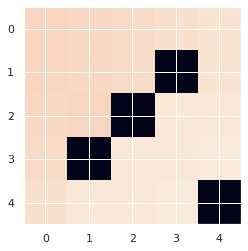

In [15]:
plt.imshow(q_values[..., 0].T)
plt.show()

In [16]:
iterations = 200_000

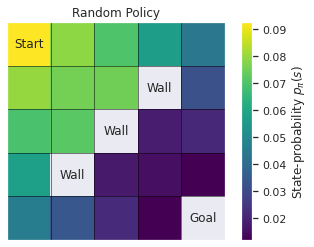

In [17]:
random_occ = np.zeros_like(q_values)

it = 0
done = True
np.random.seed(42)

while it < iterations:
    if done:
        state, info = env.reset()
        done = False

    action = np.random.randint(4)
    _, _, done, next_info = env.step(action)
    random_occ[info[0], info[1], action] += 1
    info = next_info
    it += 1

random_occ /= iterations

data = np.sum(random_occ, axis=2)
data[2, 2] = np.nan
data[3, 1] = np.nan
data[1, 3] = np.nan
data[4, 4] = np.nan

fig, ax = plt.subplots()
plt.imshow(data, cmap="viridis")
ax.text(0, 0, "Start", ha="center", va="center")
ax.text(2, 2, "Wall", ha="center", va="center")
ax.text(1, 3, "Wall", ha="center", va="center")
ax.text(3, 1, "Wall", ha="center", va="center")
ax.text(4, 4, "Goal", ha="center", va="center")
plt.tick_params(bottom = False, left=False)
ax.set_xticks(np.arange(-.5, 5, 1))
ax.set_yticks(np.arange(-.5, 5, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black', linestyle='-', linewidth=0.5)
cbar = plt.colorbar()
cbar.set_label("State-probability $p_\pi(s)$")
plt.title("Random Policy")
plt.show()

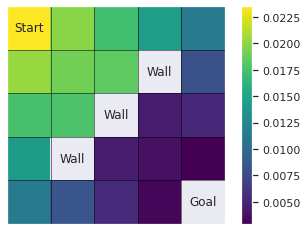

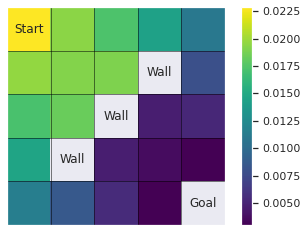

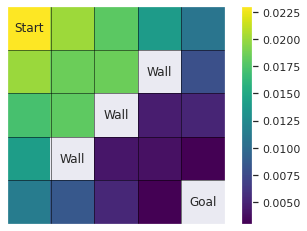

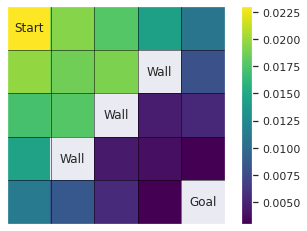

In [18]:
for i in range(4):
    data = copy.copy(random_occ[..., i])
    data[2, 2] = np.nan
    data[3, 1] = np.nan
    data[1, 3] = np.nan
    data[4, 4] = np.nan


    fig, ax = plt.subplots()
    plt.imshow(data, cmap="viridis")
    ax.text(0, 0, "Start", ha="center", va="center")
    ax.text(2, 2, "Wall", ha="center", va="center")
    ax.text(1, 3, "Wall", ha="center", va="center")
    ax.text(3, 1, "Wall", ha="center", va="center")
    ax.text(4, 4, "Goal", ha="center", va="center")
    plt.tick_params(bottom = False, left=False)
    ax.set_xticks(np.arange(-.5, 5, 1))
    ax.set_yticks(np.arange(-.5, 5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='black', linestyle='-', linewidth=0.5)
    plt.colorbar()
    plt.show()

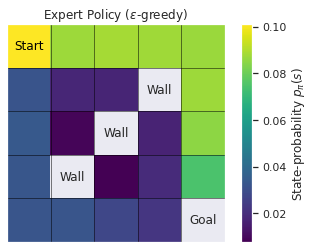

In [19]:
expert_occ = np.zeros_like(q_values)
eps = 5e-1

it = 0
done = True
np.random.seed(42)

while it < iterations:
    if done:
        state, info = env.reset()
        done = False

    if np.random.rand() < eps:
        action = np.random.randint(4)
    else:
        action = np.argmax(q_values[info[0], info[1]])
    _, _, done, next_info = env.step(action)
    expert_occ[info[0], info[1], action] += 1
    info = next_info
    it += 1

expert_occ /= iterations

data = np.sum(expert_occ, axis=2)
data[2, 2] = np.nan
data[3, 1] = np.nan
data[1, 3] = np.nan
data[4, 4] = np.nan

fig, ax = plt.subplots()
plt.imshow(data, cmap="viridis")
ax.text(0, 0, "Start", ha="center", va="center", color="w" if data[0, 0] < 0.03 else "black")
ax.text(2, 2, "Wall", ha="center", va="center")
ax.text(1, 3, "Wall", ha="center", va="center")
ax.text(3, 1, "Wall", ha="center", va="center")
ax.text(4, 4, "Goal", ha="center", va="center")
plt.tick_params(bottom = False, left=False)
ax.set_xticks(np.arange(-.5, 5, 1))
ax.set_yticks(np.arange(-.5, 5, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black', linestyle='-', linewidth=0.5)
cbar = plt.colorbar()
cbar.set_label("State-probability $p_\pi(s)$")
plt.title("Expert Policy ($\epsilon$-greedy)")
plt.show()

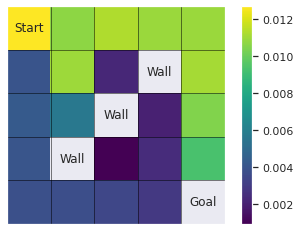

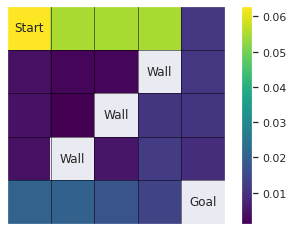

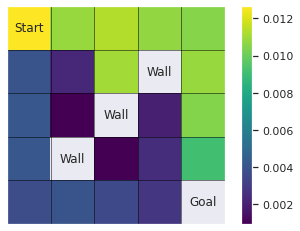

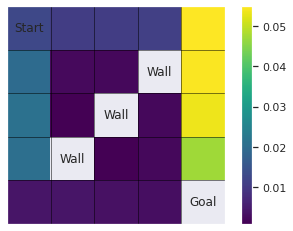

In [20]:
for i in range(4):
    data = copy.copy(expert_occ[..., i])
    data[2, 2] = np.nan
    data[3, 1] = np.nan
    data[1, 3] = np.nan
    data[4, 4] = np.nan


    fig, ax = plt.subplots()
    plt.imshow(data, cmap="viridis")
    ax.text(0, 0, "Start", ha="center", va="center")
    ax.text(2, 2, "Wall", ha="center", va="center")
    ax.text(1, 3, "Wall", ha="center", va="center")
    ax.text(3, 1, "Wall", ha="center", va="center")
    ax.text(4, 4, "Goal", ha="center", va="center")
    plt.tick_params(bottom = False, left=False)
    ax.set_xticks(np.arange(-.5, 5, 1))
    ax.set_yticks(np.arange(-.5, 5, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color='black', linestyle='-', linewidth=0.5)
    plt.colorbar()
    plt.show()

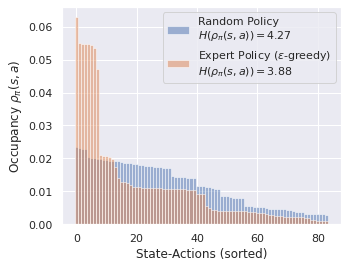

In [21]:
idx = np.where(random_occ > 0)
random_ent = - np.sum(random_occ[idx] * np.log(random_occ[idx]))
idx = np.where(expert_occ > 0)
expert_ent = - np.sum(expert_occ[idx] * np.log(expert_occ[idx]))


plt.figure(figsize=(5, 4))
plt.bar(list(range(np.count_nonzero(random_occ))), np.sort(random_occ.flatten())[::-1][:np.count_nonzero(random_occ)], width=1, alpha=0.5, label=f"Random Policy\n$H(\\rho_\pi(s, a))={round(random_ent, 2)}$")
plt.bar(list(range(np.count_nonzero(expert_occ))), np.sort(expert_occ.flatten())[::-1][:np.count_nonzero(expert_occ)], width=1, alpha=0.5, label=f"Expert Policy ($\epsilon$-greedy)\n$H(\\rho_\pi(s, a))={round(expert_ent, 2)}$")
plt.ylabel("Occupancy $\\rho_\pi(s, a)$")
plt.xlabel("State-Actions (sorted)")
plt.legend()
plt.show()

Combined plot

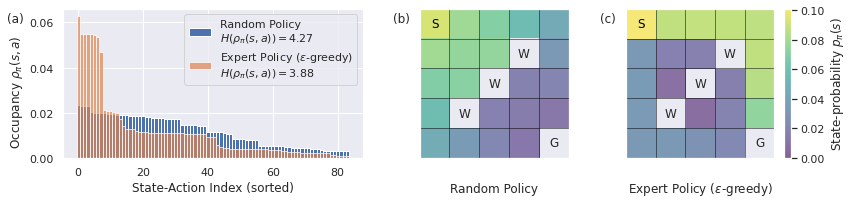

In [22]:
vmin, vmax = 0, np.max([np.sum(random_occ, axis=2), np.sum(expert_occ, axis=2)])

cmap = "viridis"
#sns.cubehelix_palette(as_cmap=True, reverse=True)
#sns.color_palette("mako", as_cmap=True)
#sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse=True)

fig, axs = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'width_ratios': [1, 1, 0.62]})

axs[0].bar(list(range(np.count_nonzero(random_occ))), np.sort(random_occ.flatten())[::-1][:np.count_nonzero(random_occ)], width=1, alpha=1, label=f"Random Policy\n$H(\\rho_\pi(s, a))={round(random_ent, 2)}$")
axs[0].bar(list(range(np.count_nonzero(expert_occ))), np.sort(expert_occ.flatten())[::-1][:np.count_nonzero(expert_occ)], width=1, alpha=0.7, label=f"Expert Policy ($\epsilon$-greedy)\n$H(\\rho_\pi(s, a))={round(expert_ent, 2)}$")
#axs[0].set_xlim(xmin=-2, xmax=max(np.count_nonzero(random_occ), np.count_nonzero(expert_occ))+1)
axs[0].set_ylabel("Occupancy $\\rho_\pi(s, a)$     ")
axs[0].set_xlabel("State-Action Index (sorted)")
axs[0].legend()

data = np.sum(random_occ, axis=2)
data[2, 2] = np.nan
data[3, 1] = np.nan
data[1, 3] = np.nan
data[4, 4] = np.nan


axs[1].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6)
axs[1].text(0, 0, "S", ha="center", va="center", color="w" if data[0, 0] < 0.03 else "black")
axs[1].text(2, 2, "W", ha="center", va="center")
axs[1].text(1, 3, "W", ha="center", va="center")
axs[1].text(3, 1, "W", ha="center", va="center")
axs[1].text(4, 4, "G", ha="center", va="center")
axs[1].tick_params(bottom = False, left=False)
axs[1].set_xticks(np.arange(-.5, 5, 1))
axs[1].set_yticks(np.arange(-.5, 5, 1))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[1].grid(color='black', linestyle='-', linewidth=0.5)
axs[1].set_title("Random Policy", y=-0.27)


data = np.sum(expert_occ, axis=2)
data[2, 2] = np.nan
data[3, 1] = np.nan
data[1, 3] = np.nan
data[4, 4] = np.nan

cax = axs[2].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.6)
axs[2].text(0, 0, "S", ha="center", va="center", color="w" if data[0, 0] < 0.03 else "black")
axs[2].text(2, 2, "W", ha="center", va="center")
axs[2].text(1, 3, "W", ha="center", va="center")
axs[2].text(3, 1, "W", ha="center", va="center")
axs[2].text(4, 4, "G", ha="center", va="center")
axs[2].tick_params(bottom = False, left=False)
axs[2].set_xticks(np.arange(-.5, 5, 1))
axs[2].set_yticks(np.arange(-.5, 5, 1))
axs[2].set_xticklabels([])
axs[2].set_yticklabels([])
axs[2].grid(color='black', linestyle='-', linewidth=0.5)
axs[2].set_title("Expert Policy ($\epsilon$-greedy)", y=-0.27)

plt.tight_layout(rect=[0,0,0.96, 1])

fig.text(0.014, 0.88, '(a)')
fig.text(0.46, 0.88, '(b)')
fig.text(0.7, 0.88, '(c)')

cbar = fig.colorbar(cax, ax=axs[2]).set_label("State-probability $p_\pi(s)$")
os.makedirs(os.path.join("..", "..", "results"), exist_ok=True)
plt.savefig(os.path.join("..", "..", "results", "occupancy.pdf"))
plt.show()